In [1]:
import torch
import torch.nn as nn 
import seaborn as sns
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [3]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,949,964,969,981,989,998,1004,1029,1050,1076
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,761,762,762,762,762,762,763,763,763,763
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,52,52,58,60,61,69,70,70,71,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,251,251,251,251,251,251,299,441,443,458
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,167,184,197,209,212,222,233,249,256,278
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,11,34,34,78,78,87,87,87,87,87
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,1936,2140,2350,2551,2738,2929,3100,3266,3424,3563


In [5]:
df = df[df['Country/Region'] == 'Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20
139,NaN,Japan,36.0,138.0,2,2,2,2,4,4,...,16367,16367,16424,16513,16536,16550,16581,16623,16651,16598


In [6]:
df = df.iloc[:,4:].copy()
df['4/16/20'] = [8626]
daily_japan = df.iloc[0,:]
daily_japan.index = pd.to_datetime(daily_japan.index)

daily_japan

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-05-24    16550
2020-05-25    16581
2020-05-26    16623
2020-05-27    16651
2020-05-28    16598
Name: 139, Length: 128, dtype: int64

/Users/macuser/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


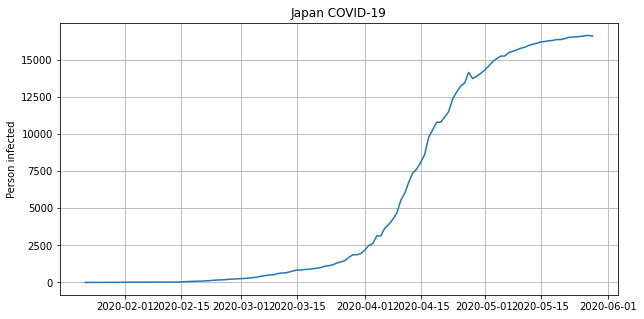

In [7]:
plt.figure(figsize=(10,5))
plt.plot(daily_japan)
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.show()

In [8]:
y = daily_japan.values.astype(float)

In [9]:
def sequence_creator(input_data, window):
    dataset = []
    data_len = len(input_data)
    for i in range(data_len - window):
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1]
        dataset.append((window_fr, label))
    return dataset

In [10]:
class LSTM_COVID(nn.Module):

    def __init__(self, in_size=1, h_size=30, out_size=1):
        super().__init__()
        self.h_size = h_size
        self.lstm = nn.LSTM(in_size, h_size)
        self.fc = nn.Linear(h_size, out_size)
        self.hidden = (torch.zeros(1,1,self.h_size), torch.zeros(1,1,self.h_size))
    def forward(self, sequence_data):
        lstm_out, self.hidden = self.lstm(sequence_data.view(len(sequence_data),1,-1), self.hidden)
        pred = self.fc(lstm_out.view(len(sequence_data),-1)
        )
        return pred[-1]

In [11]:
torch.manual_seed(3)
model = LSTM_COVID()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
epochs = 100
window_size = 7
loss_list = []
loss_temp = 0

In [14]:
scaler = MinMaxScaler(feature_range=(-1,1))
y_normalized = scaler.fit_transform(y.reshape(-1,1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = sequence_creator(y_normalized, window_size)

In [22]:
for epoch in range(epochs):
    for sequence_in, y_train in full_data:
        y_pred = model(sequence_in)
        loss = criterion(y_pred, y_train)
        loss_temp += loss
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size), torch.zeros(1,1,model.h_size))
        loss.backward()
        optimizer.step()

    if((epoch+1) % 10 == 0):
        loss_list.append(loss_temp.item() / (10 * len(full_data)))
        print(f'Epoch {epoch+1} Loss {loss_temp.item() / (10 * len(full_data))}')
        loss_temp = 0

Epoch 10 Loss 0.0028645034663933367
Epoch 20 Loss 0.0033912288255927977
Epoch 30 Loss 0.003538920662619851
Epoch 40 Loss 0.003037826679954844
Epoch 50 Loss 0.0030228585251106705
Epoch 60 Loss 0.009808329117199607
Epoch 70 Loss 0.0022480446445055243
Epoch 80 Loss 0.00314819930998747
Epoch 90 Loss 0.00433060039173473
Epoch 100 Loss 0.004797267519738063


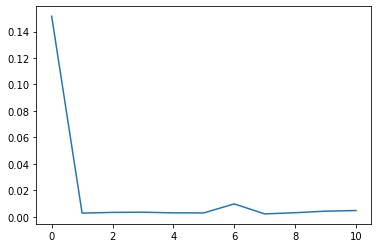

In [23]:
plt.plot(loss_list)

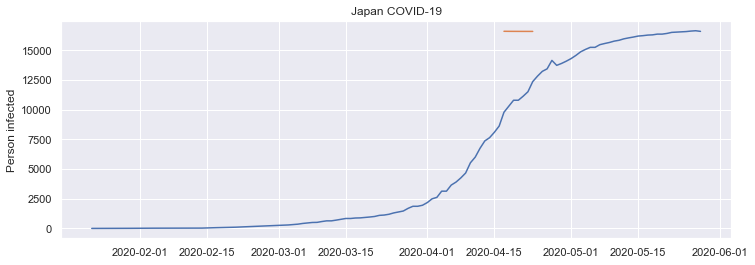

In [24]:
upcoming_future = 7
predictions = y_normalized[-window_size:].tolist()
model.eval()
for i in range(upcoming_future):
    sequence = torch.FloatTensor(predictions[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.h_size), torch.zeros(1,1,model.h_size))
        predictions.append(model(sequence).item())

predictions_y = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
x = np.arange('2020-04-17', '2020-04-24', dtype='datetime64[D]').astype('datetime64[D]')
sns.set()
plt.figure(figsize=(12,4))
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.plot(daily_japan)
plt.plot(x, predictions_y[-window_size:])
plt.show()

In [25]:
predictions_y[-window_size:]

array([[16605.36692593],
       [16600.98268947],
       [16598.83026555],
       [16597.22264603],
       [16596.10922065],
       [16595.44235626],
       [16595.2041904 ]])